In [17]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy.polynomial.polynomial as poly
from numpy.polynomial import Polynomial
import scipy.constants as const

#Configuration for the font and style in the graphics
params = {
        'font.family': 'serif',
        'font.serif': ['STIXGeneral', 'Times New Roman'],
        'font.size': 12,
        'axes.labelsize': 12,
        'axes.titlesize': 14,
        'legend.fontsize': 13,
        'xtick.labelsize': 13,
        'ytick.labelsize': 13,
        'mathtext.fontset': 'stix',
        'text.usetex': False,
        'figure.figsize': (6.4, 4.8),
        'savefig.format': 'pdf',
        'savefig.bbox': 'tight'
    }
    
plt.rcParams.update(params)

In [ ]:
#Data from vizier without treatment
raw_data = pd.read_csv(r"C:\Users\clauw\Documents\Programming\NIR_data_vizier.tsv", delimiter='\t',names=["Wave (cm)", "nFlux", "rFlux"])

In [3]:
#Convert the wavelength in A cause its in cm^-1 
raw_data['Wave A'] = (10**(8))/raw_data['Wave (cm)']

#Invert the values for the index in python
raw_data = raw_data.sort_values('Wave A', ascending=True, na_position='first').reset_index(drop=True)

raw_data

,Wave (cm),nFlux,rFlux,Wave A
0,9999.998732,0.996949,0.134761,10000.001268
1,9999.996849,0.997237,0.134800,10000.003151
2,9999.994966,0.997245,0.134802,10000.005034
3,9999.993083,0.996937,0.134760,10000.006917
4,9999.991199,0.997067,0.134778,10000.008801
...,...,...,...,...
3001255,4347.829323,0.944661,0.015909,22999.982882
3001256,4347.827440,0.938258,0.015800,22999.992845
3001257,4347.825556,0.934484,0.015736,23000.002807
3001258,4347.823673,0.930303,0.015666,23000.012770


In [4]:
#Lines from the excel file
raw_lambda = pd.read_excel(r"C:\Users\clauw\Documents\Programming\Final-Project\Project\IAG Solar Flux Atlas\Infrared range\Data\new_values_fe.xlsx")

raw_lambda

,Nave list
0,10035.6094
1,10084.1584
2,10116.7892
3,10139.8807
4,10145.6242
...,...
151,17165.7965
152,17209.0026
153,17307.0446
154,17315.5826


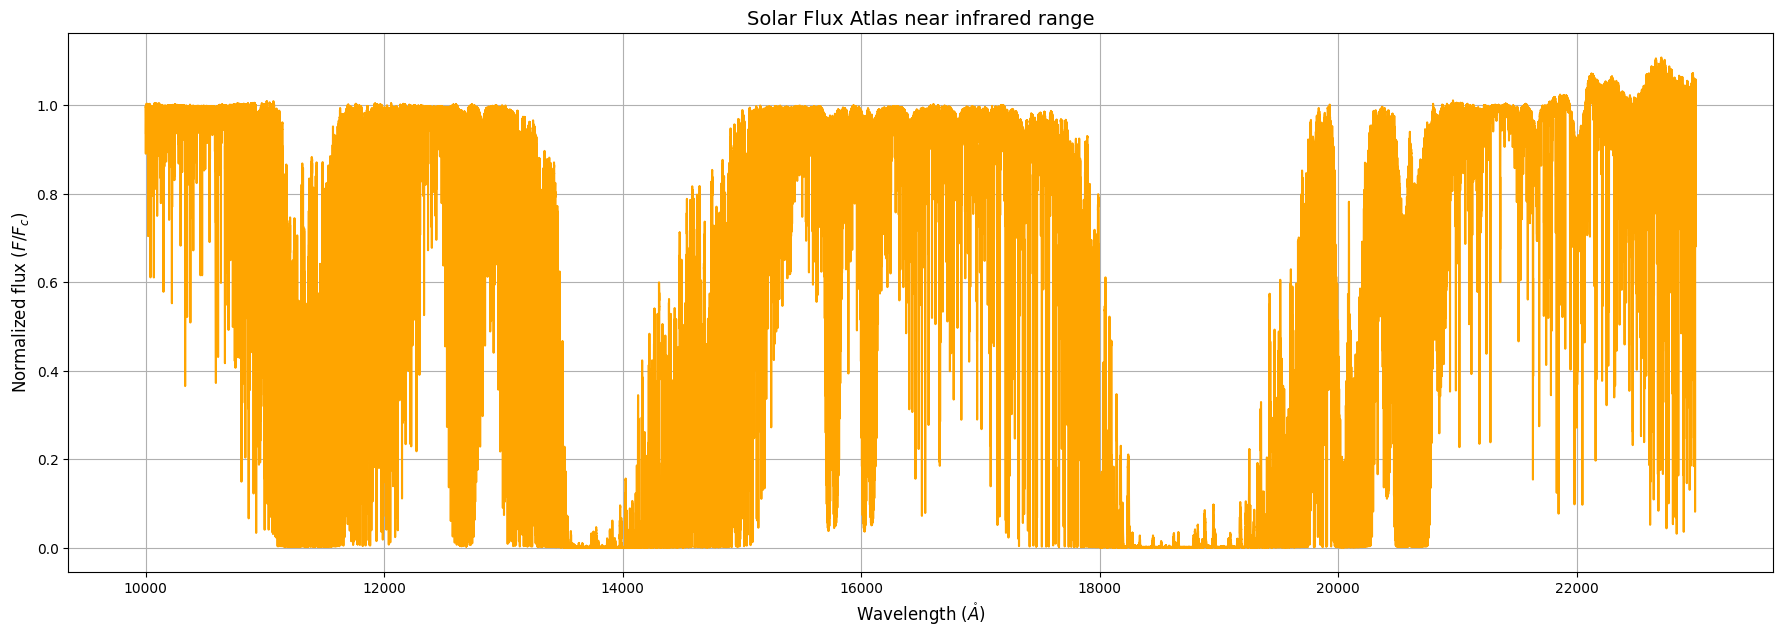

In [ ]:
#Plot of raw data
fig1, ax = plt.subplots(1,1,figsize=(22,7))
ax.plot(raw_data['Wave A'],raw_data['nFlux'], color='orange')
ax.set_title('Solar Flux Atlas near infrared range')
ax.set_xlabel(r'Wavelength $(\mathring{A})$')
ax.set_ylabel(r'Normalized flux $(F/F_{c})$')
ax.grid()

# fig1.savefig('Spectrum_NIR.png')

### Find the minimums and the closer line of the value in Nave list


In [ ]:
#Find the minimum or the lambda in the spectrum
def find_minimums(wave,flux,lamda):
    #The function find_peaks just got the index of the points
    #The minus if for the minimums, without it are the maximums
    minimums,_ = find_peaks(-flux) 
    mindf = pd.DataFrame([]) #Make a dataframe
    mindf['min_wave'] = wave[minimums]
    mindf['min_flux'] = flux[minimums]

    #Take the closer line with the absolute value of the difference between the minimums and the line
    #This step dont include the closer points that are not minimums
    closer = []
    for each in lamda:
        mindf['abs'] = np.abs(mindf['min_wave']-each)
        closer.append(mindf.loc[mindf['abs'] == min(mindf['abs'])]) #Take all the row

    #Dataframe with the marks for the closer lines of Fe I
    closer_data = pd.concat(closer,axis=0).reset_index(drop=True)
    closer_data['Fe line'] = lamda

    return closer_data.drop(['abs'],axis=1)


closer_lines = find_minimums(raw_data['Wave A'],raw_data['nFlux'],raw_lambda['Nave list'])

,min_wave,min_flux,Fe line
0,10035.604601,0.942222,10035.6094
1,10084.158793,0.956740,10084.1584
2,10116.792043,0.892242,10116.7892
3,10139.882291,0.945517,10139.8807
4,10145.624806,0.916598,10145.6242
...,...,...,...
151,17165.802256,0.751678,17165.7965
152,17209.006814,0.726609,17209.0026
153,17307.053438,0.700318,17307.0446
154,17315.586883,0.928187,17315.5826


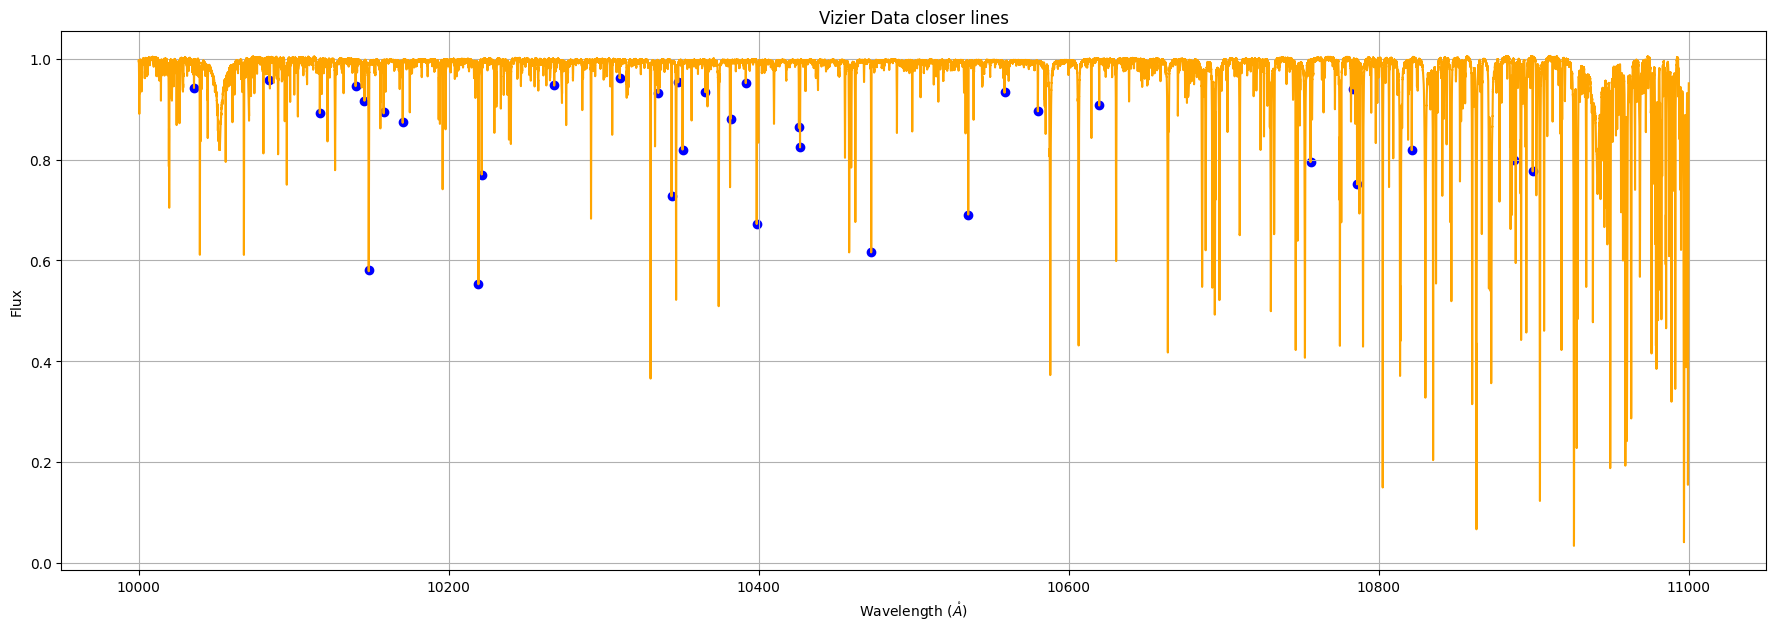

In [7]:
#Plot the identified lines
data_10000_11000 = raw_data[raw_data['Wave A'].between(10000, 11000, inclusive='neither')].reset_index(drop=True)
closer_lines_10000_11000 = closer_lines[closer_lines['Fe line'].between(10000, 11000, inclusive='neither')].reset_index(drop=True)

fig2, ax = plt.subplots(1,1,figsize=(22,7))
ax.plot(data_10000_11000['Wave A'],data_10000_11000['nFlux'], color='orange')
ax.scatter(closer_lines_10000_11000['min_wave'],closer_lines_10000_11000['min_flux'], color='blue')
ax.set_title('Vizier Data closer lines')
ax.set_xlabel(r'Wavelength $(\mathring{A})$')
ax.set_ylabel('Flux')
ax.grid()

In [ ]:
#Localize the line and save the width for each one
def width_minimums(closer_lines,data,width):
    local_points =[]
    for each in closer_lines['min_wave']:
        #This append all the part of the dataframe in that range
        local_points.append(data[data['Wave A'].between(each-width, each+width, inclusive='neither')])

    return local_points

local_points = width_minimums(closer_lines,raw_data,0.05)#The range is 0.05mA

### Derivates and fit

In [27]:
def Fit_derivates(local_points,lamda_list,N):
    values = []
    fit = []
    cov = []

    for i in range(0,len(local_points)):

        data_wave, data_flux = local_points[i]['Wave A'], local_points[i]['nFlux'] #The index i correspond at one line in the lambda_list of Fe I lines 

        #Standarization, with the mean and std just for the big data (wavenumber)
        wave_mean, wave_std = np.mean(data_wave), np.std(data_wave) 
        wave_scaled = (data_wave - wave_mean)/wave_std if wave_std != 0 else data_wave #Take the conditional for the division in zero

        #Use polyfit only for the covariance matrix

        #Define new data with the number of points for the points, this is just for the statistical analysis
        new_wave = np.linspace(min(wave_scaled),max(wave_scaled),N)
        new_flux = np.linspace(min(data_flux),max(data_flux),N)

        #Covariance matrix for the polynomial fit coefficients scaled for the standarization
        _ , cov_matrix = np.polyfit(new_wave, new_flux, 4,cov=True)

        #Polynomial Fit is better for numerical aproximation than polyfit
        pol = Polynomial.fit(wave_scaled, data_flux, 4)

        #Scaled coeficients of fit
        param = pol.convert().coef

        #Calculate the derivates without evaluate the point, polyder takes the derivate of the polinomium
        d_param = poly.polyder(param) #First
        d2_param = poly.polyder(d_param) #Second
        d3_param = poly.polyder(d2_param) #Third

        #The fit values, taking into account the number of points defined on the covariance matrix
        flux_fit = poly.polyval(new_wave,param)

        #Find the minimum with the regression and derivates
        roots = poly.polyroots(d_param).real #Roots or critical points
        valid_roots = np.array([x for x in roots if poly.polyval(x,d2_param)>0] )#Check with the second derivate, just positive values for minimums
        
        if valid_roots.size >0: 

            value_roots = pol(valid_roots) #Evaluate in the polinomium for the global minimum
            minimal_root = valid_roots[np.where(value_roots == min(value_roots))][0] , min(value_roots) #Take the values for the wavelength and the flux of the minimum

            #For the wavelength observed convert the minimal root in the real with the scale of the mean, we dont scale the flux data
            lamda_obs = [round(minimal_root[0]*wave_std + wave_mean,4), minimal_root[1]]

            #Expresion for the third derivate (C-curved profile bisector)
            def Third_Derivate(second, third):
                return -((third)/(3*(second**2)))*(const.c/lamda_obs[0])

            #Evaluate the second and third derivate in the wavelength observed. Re-scalated the coefficients
            d2 = (poly.polyval(minimal_root[0],d2_param) / (wave_std ** 2)) 
            d3 = (Third_Derivate(d2, poly.polyval(minimal_root[0],d3_param) / (wave_std ** 3) )) 

            #Calculate the velocity and convective blueshift
            blueshift = ((lamda_obs[0]/lamda_list[i]) - 1)* const.c
            velocity = round((blueshift) - 633) #Formula for relativistic aproximation

            #In order: Natural wavelength, observed wavelength, flux, velocity, Core curvature, Bisector slope, convective blueshift,line depth
            values.append(pd.DataFrame([[lamda_list[i],lamda_obs[0],lamda_obs[1],velocity,d2*(lamda_obs[0]**2),d3*(const.c/lamda_obs[0]),blueshift,1-lamda_obs[1]]])) 

            #Just in case of the visualizer take the fit values and the wave data scaled
            fit.append(pd.DataFrame({'Flux': flux_fit,'Wave': new_wave*wave_std + wave_mean}))

            #STATISTICS 
            #Scale the matrix of covariance
            cov_b = cov_matrix*wave_std

            #Second derivate but without scale
            d2_scale = poly.polyval(minimal_root[0],d2_param)

            #Gradient for derivates of coeficients with the wavelength without scale
            grad_wave = np.array([-(4*minimal_root[0]**3) / d2_scale,-(3*minimal_root[0]**2) / d2_scale, -(2*minimal_root[0]) / d2_scale,-1 / d2_scale,0  ])

            #Scale the gradient
            grad_wave = grad_wave*wave_std

            #Add the covariance and the varince of the minimum point (observed wavelength), and for the velocity
            var = grad_wave @ cov_b @ grad_wave.T
            cov.append(pd.DataFrame({'Var': var,'Error': np.sqrt(abs(var)),'Error v': (const.c / lamda_list[i]) * np.sqrt(abs(var))},index=[0]))

    Values =  pd.concat(values,axis=0).reset_index(drop=True)
    Cov =  pd.concat(cov,axis=0).reset_index(drop=True)

    Values.columns = ["Emitted wavelength", "Observed wavelength", "Flux","Velocity","Core curvature","Bisector slope","Blueshift",'Line Depth']

    return Values,fit,Cov

#The len(local_points) is for the original set, without statistical treatment.
Values,Fit,Cov = Fit_derivates(local_points,closer_lines['Fe line'],len(local_points))

Cov

,Var,Error,Error v
0,1.513446e-33,3.890303e-17,1.162145e-12
1,6.348560e-34,2.519635e-17,7.490635e-13
2,7.181332e-35,8.474274e-18,2.511195e-13
3,6.990313e-34,2.643920e-17,7.816929e-13
4,3.513959e-34,1.874556e-17,5.539114e-13
...,...,...,...
151,2.217284e-34,1.489055e-17,2.600563e-13
152,1.905617e-33,4.365338e-17,7.604714e-13
153,7.408383e-34,2.721835e-17,4.714759e-13
154,8.709607e-34,2.951204e-17,5.109553e-13


In [28]:
# Values.to_excel('valores_NIR.xlsx',index=False)

## Graphics 
As we have an absorption spectrum, the line depth is measurement one minus the flux value.

### Velocity vs Normalized Flux

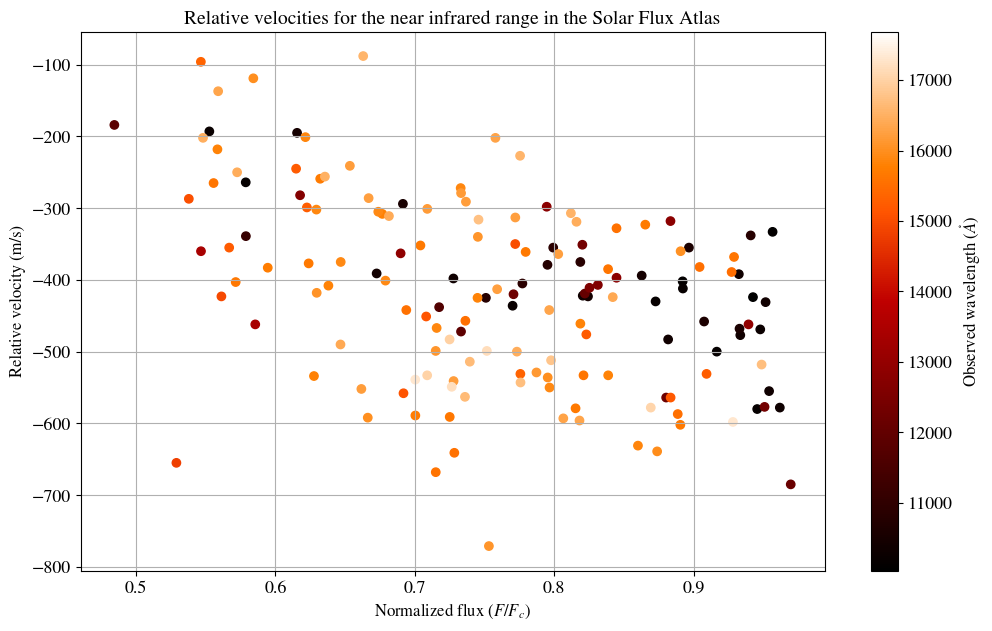

In [29]:
fig3, ax = plt.subplots(1,1,figsize=(12,7))

scatter = ax.scatter(Values['Flux'],Values['Velocity'],c=Values["Observed wavelength"],cmap='gist_heat',lw=1)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label(r'Observed wavelength $(\mathring{A})$', fontsize=12)

ax.set_title('Relative velocities for the near infrared range in the Solar Flux Atlas',fontsize=14)
ax.set_xlabel(r'Normalized flux $(F/F_{c})$', fontsize=12)
ax.set_ylabel('Relative velocity (m/s)', fontsize=12)
ax.grid()

# fig3.savefig('Velocity_NIR.png')

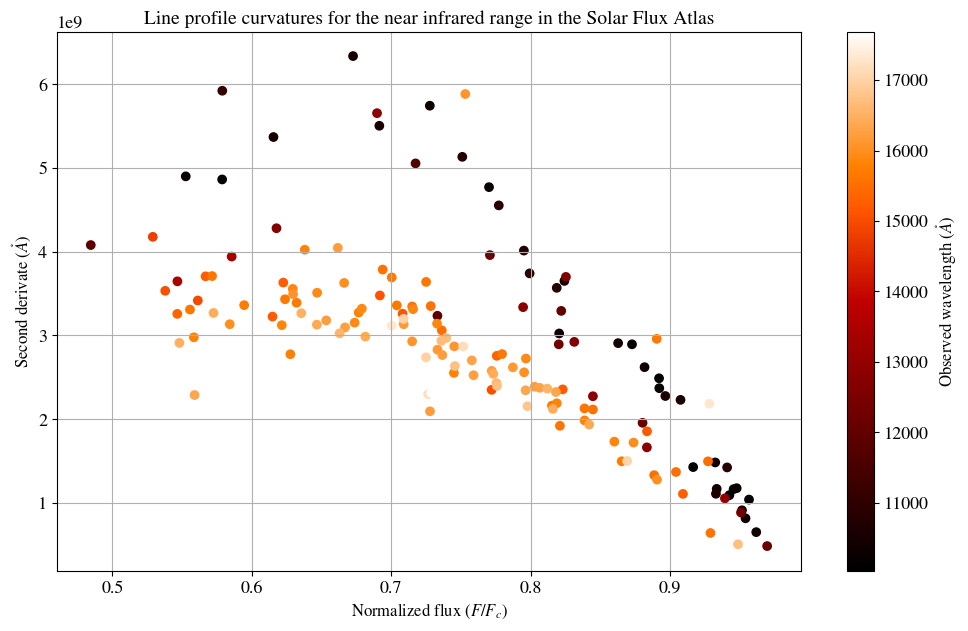

In [30]:
fig4, ax = plt.subplots(1,1,figsize=(12,7))

scatter = ax.scatter(Values['Flux'],Values['Core curvature'],c=Values["Observed wavelength"],cmap='gist_heat',lw=1)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label(r'Observed wavelength $(\mathring{A})$', fontsize=12)

ax.set_title('Line profile curvatures for the near infrared range in the Solar Flux Atlas',fontsize=14)
ax.set_xlabel(r'Normalized flux $(F/F_{c})$',fontsize=12)
ax.set_ylabel(r'Second derivate $(\mathring{A})$',fontsize=12)
ax.grid()

# fig4.savefig('Curvature_NIR.png')

### Third Derivate Expresion vs Normalized Flux

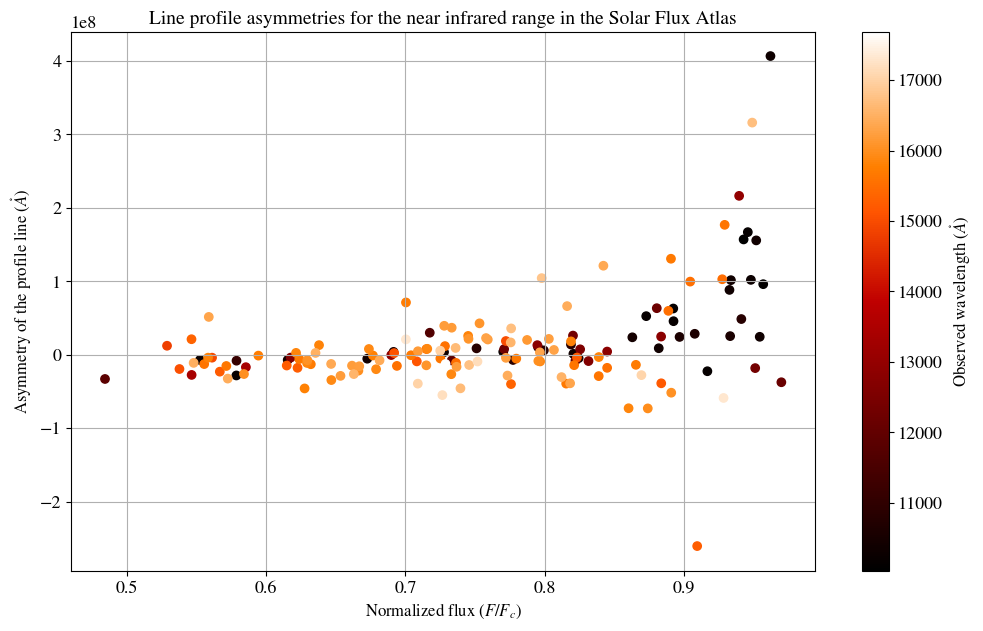

In [31]:
fig5, ax = plt.subplots(1,1,figsize=(12,7))

scatter = ax.scatter(Values['Flux'],Values['Bisector slope'],c=Values["Observed wavelength"],cmap='gist_heat',lw=1)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label(r'Observed wavelength $(\mathring{A})$', fontsize=12)

ax.set_title('Line profile asymmetries for the near infrared range in the Solar Flux Atlas',fontsize=14)
ax.set_xlabel(r'Normalized flux $(F/F_{c})$',fontsize=12)
ax.set_ylabel(r'Asymmetry of the profile line $(\mathring{A})$',fontsize=12)
ax.grid()

# fig5.savefig('CBisector_NIR.png')

### Convective Blueshift vs Line Depth

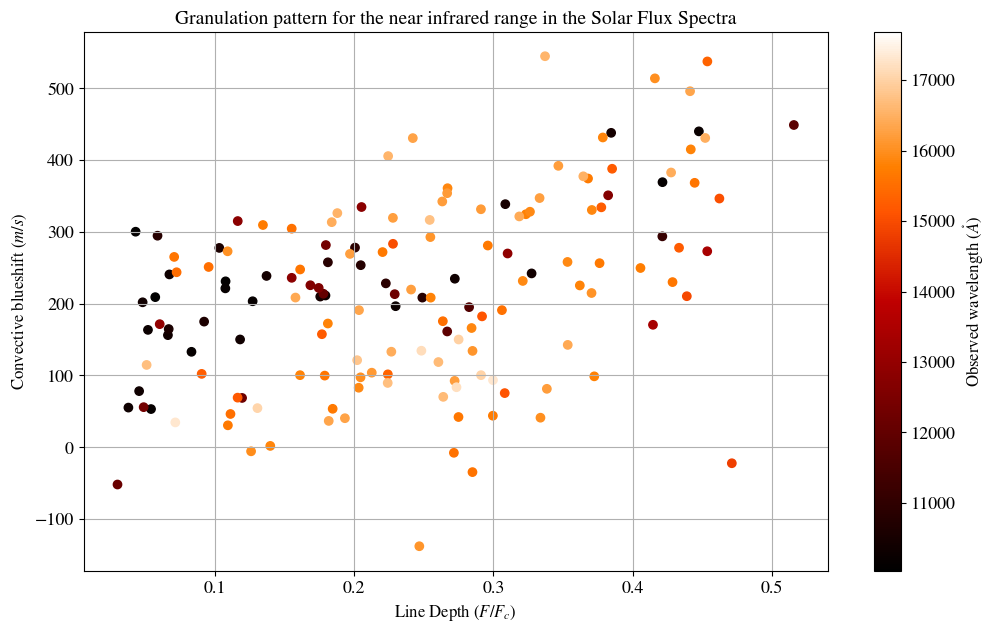

In [32]:
fig6, ax = plt.subplots(1,1,figsize=(12,7))

scatter = ax.scatter(1-Values['Flux'],Values['Blueshift'],c=Values["Observed wavelength"],cmap='gist_heat',lw=1)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label(r'Observed wavelength $(\mathring{A})$', fontsize=12)

ax.set_title('Granulation pattern for the near infrared range in the Solar Flux Spectra',fontsize=14)
ax.set_xlabel(r'Line Depth $(F/F_{c})$',fontsize=12)
ax.set_ylabel(r'Convective blueshift $(m/s)$',fontsize=12)
ax.grid()

# fig6.savefig('ConvectiveBlueshift_NIR.png')

## Statistics

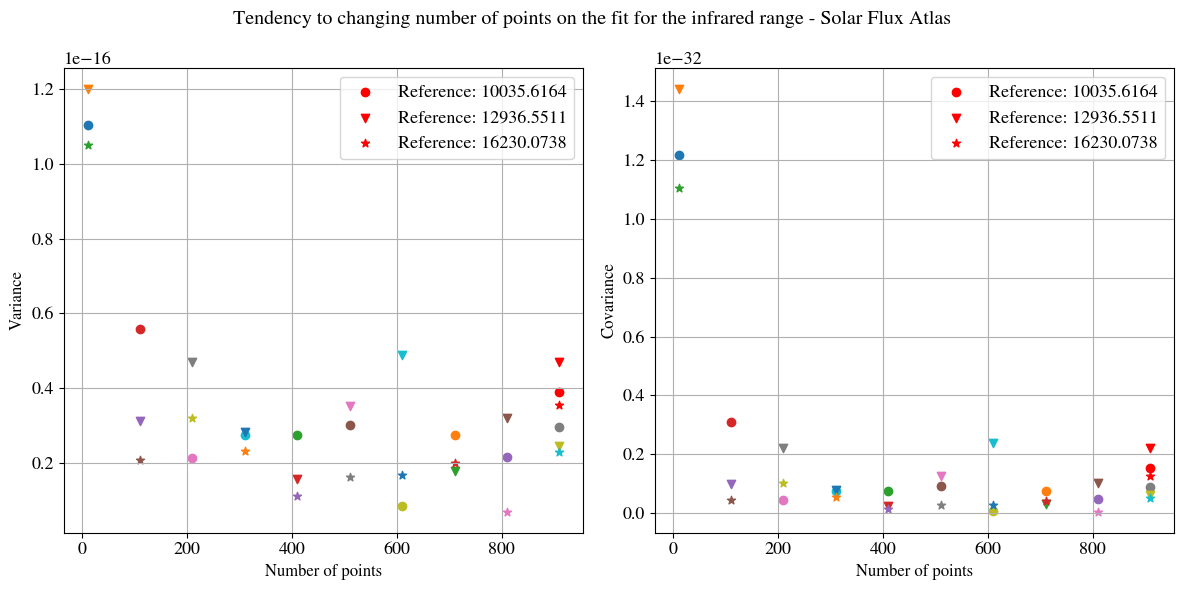

In [33]:
N_list = np.arange(10,1000,100) #Take different numbers for the 

fig7, axis1 = plt.subplots(1,2, figsize = (12,6))
ax1 = axis1[0]
ax2 = axis1[1]

fig7.suptitle(r'Tendency to changing number of points on the fit for the infrared range - Solar Flux Atlas')

for each in N_list:
    Values_,Fit_,Cov_ = Fit_derivates(local_points,closer_lines['Fe line'],each)

    ax1.scatter(each, Cov_['Error'][0],marker='o')
    ax2.scatter(each, Cov_['Var'][0],marker='o')

    ax1.scatter(each, Cov_['Error'][50],marker='v')
    ax2.scatter(each, Cov_['Var'][50],marker='v')

    ax1.scatter(each, Cov_['Error'][122],marker='*')
    ax2.scatter(each, Cov_['Var'][122],marker='*')

ax1.scatter(each, Cov['Error'][0],marker='o',color='red',label='Reference: {}'.format(Values_['Observed wavelength'][0]))
ax2.scatter(each, Cov['Var'][0],marker='o',color='red',label='Reference: {}'.format(Values_['Observed wavelength'][0]))

ax1.scatter(each, Cov['Error'][50],marker='v',color='red',label='Reference: {}'.format(Values_['Observed wavelength'][50]))
ax2.scatter(each, Cov['Var'][50],marker='v',color='red',label='Reference: {}'.format(Values_['Observed wavelength'][50]))

ax1.scatter(each, Cov['Error'][122],marker='*',color='red',label='Reference: {}'.format(Values_['Observed wavelength'][122]))
ax2.scatter(each, Cov['Var'][122],marker='*',color='red',label='Reference: {}'.format(Values_['Observed wavelength'][122]))


ax1.grid()
ax1.legend()
ax1.set_xlabel(r'Number of points')
ax1.set_ylabel(r'Variance')
ax1.tick_params(axis='both')


ax2.grid()
ax2.legend()
ax2.set_xlabel(r'Number of points')
ax2.set_ylabel(r'Covariance')
ax2.tick_params(axis='both')

fig7.tight_layout()

# fig7.savefig('Covariance_NIR.pdf')

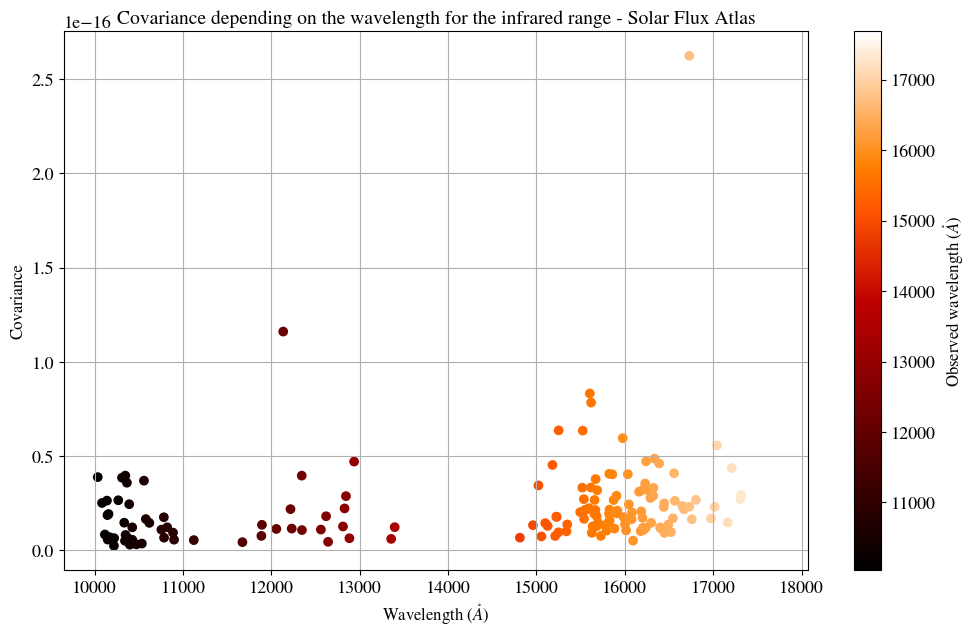

In [34]:
fig8, ax = plt.subplots(1,1,figsize=(12,7))

scatter = ax.scatter(Values["Observed wavelength"],Cov['Error'],c=Values["Observed wavelength"],cmap='gist_heat',lw=1)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label(r'Observed wavelength $(\mathring{A})$')

ax.set_title('Covariance depending on the wavelength for the infrared range - Solar Flux Atlas')
ax.set_xlabel(r'Wavelength $(\mathring{A})$')
ax.set_ylabel(r'Covariance')
ax.grid()

# fig8.savefig('Cov_wave_NIR.pdf')